<a href="https://colab.research.google.com/github/Aaditya-ops-cpu/Aaditya-ops-cpu/blob/main/Team_VAUV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving adi.png to adi (7).png


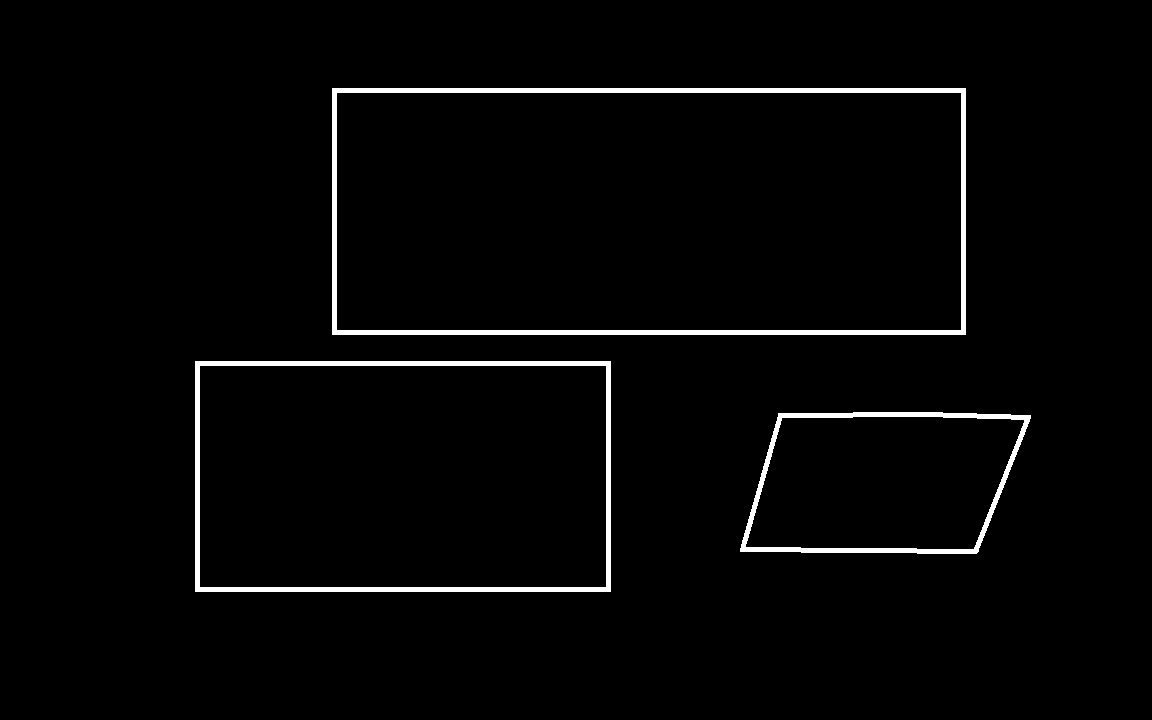

[np.float32(104.25887), np.float32(69.33525), np.float32(111.315865), np.float32(75.08999)]
[np.float32(90.0), np.float32(90.0), np.float32(90.0), np.float32(90.0)]
[np.float32(90.0), np.float32(90.0), np.float32(90.0), np.float32(90.0)]
✅ Detected 3 shapes successfully!


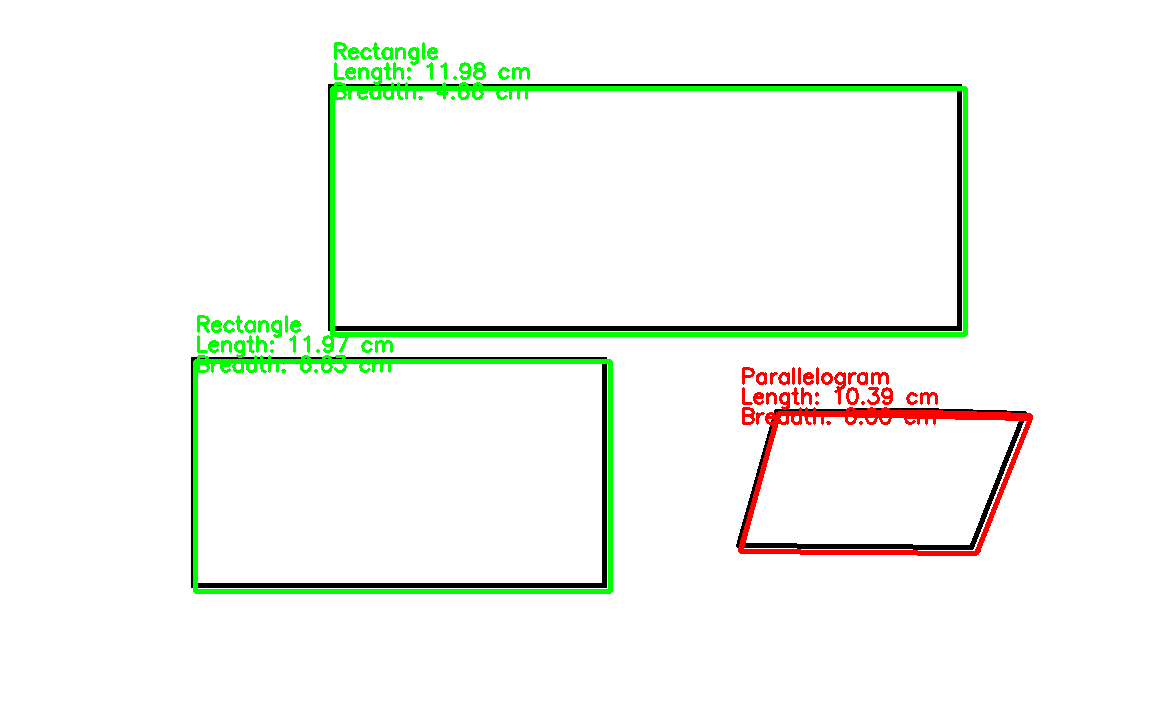

In [14]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow
from google.colab import files

# ---- CONFIG ----
# IMAGE_PATH = "rectangle.jpg"  # your uploaded image
#FOCAL_LENGTH = 500         # example calibration
#REAL_WIDTH_CM = 12            # actual width of shape in cm

# ---- Helper: Angle between 3 points ----
def angle(pt1, pt2, pt0):
    dx1 = pt1[0] - pt0[0]
    dy1 = pt1[1] - pt0[1]
    dx2 = pt2[0] - pt0[0]
    dy2 = pt2[1] - pt0[1]

    # Compute lengths safely
    len1 = np.hypot(dx1, dy1)
    len2 = np.hypot(dx2, dy2)

    if len1 == 0 or len2 == 0:
        return 0.0  # degenerate case

    cos_angle = (dx1 * dx2 + dy1 * dy2) / (len1 * len2)

    # Clamp to [-1, 1] to prevent math domain error
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    return math.degrees(math.acos(cos_angle))
# ---- Helper: Order rectangle points ----
def order_rect_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect[0] = pts[np.argmin(s)]    # top-left
    rect[2] = pts[np.argmax(s)]    # bottom-right
    rect[1] = pts[np.argmin(diff)] # top-right
    rect[3] = pts[np.argmax(diff)] # bottom-left
    return rect

# ---- Helper: Compute angle at corner ----
def corner_angle(p0, p1, p2):
    v1 = np.array(p1) - np.array(p0)
    v2 = np.array(p2) - np.array(p0)
    dot = np.dot(v1, v2)
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm == 0:
        return 0
    cos = np.clip(dot / norm, -1.0, 1.0)
    return np.degrees(np.arccos(cos))


# ---- Load and preprocess ----
uploaded = files.upload()
if not uploaded:
  print("No file uploaded.")
else:
  image_path = next(iter(uploaded))
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Adaptive threshold handles uneven lighting
  blur = cv2.GaussianBlur(gray, (5, 5), 0)
  thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 15, 4)

  # Morphology cleanup
  kernel = np.ones((2, 2), np.uint8)

  # Remove small white specks (opening)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

  # thresh = cv2.dilate(thresh, kernel, iterations=1)
  # Fill small black holes inside objects (closing)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

  # print("kernel")
  # cv2_imshow(kernel)
  # print("thresh")
  cv2_imshow(thresh)

  # ---- Find contours ----
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  shapes_found = 0

  # print(contours)

  for cnt in contours:
      area = cv2.contourArea(cnt)
      if area < 1000:  # skip small noise
          continue

      # cv2_imshow(img)

      # print(f"{cnt}---{area}")
      # Refine the approximation parameter here (0.115)
      approx = cv2.approxPolyDP(cnt, 0.115 * cv2.arcLength(cnt, True), True)
      # print("a",approx)
      for point in cnt:
        x, y = point[0]
        cv2.circle(img, (x, y), 2, (0, 0, 255), -1)  # small red dot
      # print(approx)
      if len(approx) == 4:
          pts = approx.reshape(4, 2)
          pts = order_rect_points(pts)

          # Compute angles
          angles = [corner_angle(pts[i], pts[(i-1)%4], pts[(i+1)%4]) for i in range(4)]
          # Classify based on angles
          print(angles)
          if all(85 < ang < 95 for ang in angles):
              shape = "Rectangle"
              color = (0, 255, 0)
          else:
              shape = "Parallelogram"
              color = (0, 0, 255)

          # Distance estimation
          x, y, w, h = cv2.boundingRect(approx)
          pixel_width = w
          distance_cm = (FOCAL_LENGTH * REAL_WIDTH_CM) / pixel_width

          # Calculate length and breadth in pixels
          side1 = np.linalg.norm(pts[0] - pts[1])
          side2 = np.linalg.norm(pts[1] - pts[2])
          length_px = max(side1, side2)
          breadth_px = min(side1, side2)

          # Convert to cm (assuming the REAL_WIDTH_CM corresponds to the longer side in the image)
          # This is a simplification; a more accurate method would require a reference object in the image
          length_cm = (length_px / pixel_width) * REAL_WIDTH_CM
          breadth_cm = (breadth_px / pixel_width) * REAL_WIDTH_CM


          # Draw
          cv2.drawContours(img, [approx], 0, color, 3)
          cv2.putText(img, f"{shape} ", (x, y - 30),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
          cv2.putText(img, f"Length: {length_cm:.2f} cm", (x, y - 10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
          cv2.putText(img, f"Breadth: {breadth_cm:.2f} cm", (x, y + 10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)


          shapes_found += 1

  if shapes_found == 0:
      print("⚠️ No shapes detected. Try improving lighting or increasing area threshold sensitivity.")
  else:
      print(f"✅ Detected {shapes_found} shapes successfully!")

  cv2_imshow(img)